# Setup

Force Sensor

In [17]:
import nidaqmx 
import atiiaftt as ati
from nidaqmx.stream_readers import AnalogMultiChannelReader
import time as Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ftsensor

In [18]:
sensor = ftsensor.ftsensor(tool_offset=[0,0,52,0,0,0])
# sensor.set_read_freq(5)
sensor.start_task()
sensor.set_bias()
sensor.stop_task()
print("Current Bias (in Voltages) is: ", sensor.get_bias())
print("Current Bias (in FT) is: ", sensor.convertToFt(sensor.get_bias()))

Current Bias (in Voltages) is:  [-0.13605790918670294, -0.08349962068391474, 0.13053966067731174, -0.07606149173023471, 0.050608550730744516, 0.013184545568361627]
Current Bias (in FT) is:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [19]:
sensor.read_freq
sensor.get_tool_offset()
#awdrfsadfsdf

[0, 0, 52, 0, 0, 0]

Test Sensor

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\nidaqmx\task.py:97: ResourceWarning: Task of name "_unnamedTask<3>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\nidaqmx\task.py:97: ResourceWarning: Task of name "_unnamedTask<4>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\nidaqmx\task.py:97: ResourceWarning: Task of name "_unnamedTask<5>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


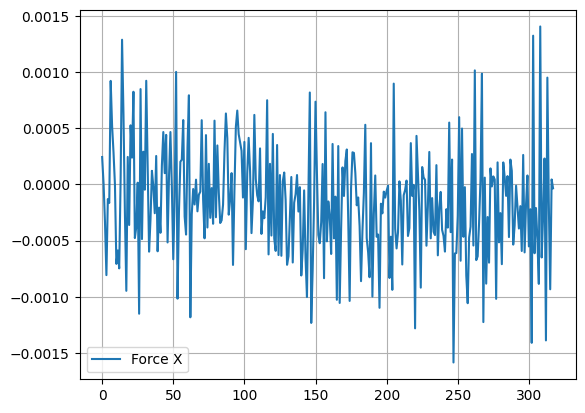

In [20]:
duration = 5
readings = []
sensor.start_task()
current_time = Time.time()

while Time.time()< current_time + duration:
    readings.append(np.array(sensor.read_ft()))

sensor.stop_task()

readings = np.array(readings)
plt.plot(range(readings.shape[0]), readings.transpose()[0], label="Force X")
plt.grid()
plt.legend()

Initiallize Motor

In [21]:
import numpy as np
import datetime as dt
import csv
import matplotlib.pyplot as plt
import serial
from time import sleep


ENTER = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFC])
EXIT = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFD])
ZERO = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFE])


# AK70-10 24V Motor Limit
P_MIN = -12.5
P_MAX = 12.5
V_MIN = -50  
V_MAX = 50
T_MIN = -25 
T_MAX = 25
KP_MIN = 0
KP_MAX = 500
KD_MIN = 0
KD_MAX = 5

Function

In [22]:
def unpack(data):
    id = data[0]
    pos = ((data[1]*(P_MAX-P_MIN))/(pow(2,16)-1)) + P_MIN
    vel = ((data[2]*(V_MAX-V_MIN))/(pow(2,12)-1)) + V_MIN
    tor = ((data[3]*(T_MAX-T_MIN))/(pow(2,12)-1)) + T_MIN
    return id, pos, vel, tor

def receive():
    global dT, q1_old, q2_old
    # Read the response from the serial port
    received = ser.readline().decode().split()      

    # Print the received bytes
    # print("Received:", received)

    try:
        test = int(received[0])
        response = [int(x) for x in received]
        [id, p, v, t] = unpack(response)

        if id == 1:
            p = -round(p,3)
            t = -t
            if dT == 0:
                v = 0
            else:
                v = round((p - q1_old)/dT,2)
        
        else:
            p = round(p,3)
            t = t
            if dT == 0:
                v = 0
            else:
                v = round((p-q2_old)/dT,2)

        # print the response from the Arduino
        # print([id, p, v, t])

    except (IndexError, ValueError):
        id = None
        p = 0
        v = 0
        t = 0
    return id, p, v, t

def pack_cmd(p_des, v_des, t_ff, kp, kd):
    bufs = []
    def float_to_uint(val, val_min, val_max, bits):
        val_norm = (val - val_min) / (val_max - val_min)
        val_int = int(round(val_norm * ((1 << bits) - 1)))
        return val_int
    
    p_int = float_to_uint(p_des, P_MIN, P_MAX, 16)
    v_int = float_to_uint(v_des, V_MIN, V_MAX, 12)
    t_int = float_to_uint(t_ff, T_MIN, T_MAX, 12)
    kp_int = float_to_uint(kp, KP_MIN, KP_MAX, 12)
    kd_int = float_to_uint(kd, KD_MIN, KD_MAX, 12)
    
    bufs.append((p_int >> 8) & 0xFF)
    bufs.append(p_int & 0xFF)
    bufs.append((v_int >> 4) & 0xFF)
    bufs.append(((v_int & 0xF) << 4) | ((kp_int >> 8) & 0xF))
    bufs.append(kp_int & 0xFF)
    bufs.append((kd_int >> 4) & 0xFF)
    bufs.append(((kd_int & 0xF) << 4) | ((t_int >> 8) & 0xF))
    bufs.append(t_int & 0xFF)

    return bufs

Construct Serial Connection

In [23]:
# open the serial port
ser = serial.Serial('COM4', 115200, timeout=1)


SerialException: could not open port 'COM4': PermissionError(13, 'Access is denied.', None, 5)

# Set Zero

In [9]:
print("Begining")


q1_old = 0
pos2_old = 0
dT = 0

#M1
print("Starting Zero Position M1")
ser.write(bytes([0x01])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x01])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()



#M2
print("Starting Zero Position M2")
ser.write(bytes([0x02])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x02])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()

print("Finishing Zero Position")


Begining
Starting Zero Position M1
Starting Zero Position M2
Finishing Zero Position


# Enter Motor and Re-bias Force Sensor

In [27]:
sensor.stop_task()

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\nidaqmx\task.py:456: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<9>" but task was already closed.
  warnings.warn(


In [33]:
##Motor

dT = 0

#M1
print("Starting Enter Motors")
ser.write(bytes([0x01])+ENTER)
[id, p, v, t] = receive()
if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

#M2
ser.write(bytes([0x02])+ENTER)
[id, p, v, t] = receive()

if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

q1_old = q1
q2_old = q2


##Sensor
sensor.start_task()
current_time = Time.time()
duration = 1
values = []
while Time.time()< current_time + duration:
    values.append(np.array(sensor.read_avg_voltage()))

values = np.array(values)
values = [ft.mean() for ft in values.transpose()]
sensor.set_bias(values)
sensor.stop_task()
print(values)

Starting Enter Motors
[-0.06301658027170076, 0.007745679546246066, 0.08927589440941965, -0.12200568289643277, -0.05236942197852954, -0.0540962151962855]


Running

In [40]:
start_time = dt.datetime.today().timestamp()
t = 0
l1 = 0.275
l2 = 0.24
l4 = 0.01
q0 = np.deg2rad(18)
logs = list()
motor_logs = list()
readings = list()

t_mapping = 1/1.35

x = l1*np.sin(q1) + l2*np.cos(q2)
y = l1*np.cos(q1) - l2*np.sin(q2)

time = 0
record_duration = 20

print("Start Controling")
sensor.start_task()
while time < record_duration:
    start_time = dt.datetime.today().timestamp()

    log = list()
    log.append(time)

    q1_old = q1
    q2_old = q2

    x_old = x
    y_old = y


    T1 = 0
    T2 = 0
    
    
    log.append(T1)
    log.append(T2)


    command1 = bytes(pack_cmd(0,0,-T1*t_mapping,0,0)) #(pos,vel,torque,kp,kd)
    command2 = bytes(pack_cmd(0,0,T2*t_mapping,0,0)) #(pos,vel,torque,kp,kd)

    #M1
    ser.write(bytes([0x01])+command1)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    #M2
    ser.write(bytes([0x02])+command2)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    log.append(t1)
    log.append(t2)

    log.append(q1)
    log.append(q2)

    x = l1*np.sin(q1) + l2*np.cos(q2)
    y = l1*np.cos(q1) - l2*np.sin(q2)

    log.append(x)
    log.append(y)

    # print(x)

    if time!= 0:
        x_dot = (x-x_old)/dT
        y_dot = (y-y_old)/dT
    
    else:
        x_dot = 0
        y_dot = 0

    log.append(x_dot)
    log.append(y_dot)

    #Estimate CF
    A = q0-q1+2*q2
    B = q0-q1
    C = q0-2*q1+q2
    D = q0+q2
    Fx = -((T1*l2*(np.sin(A)+np.sin(B))+T2*l1*(np.sin(C)-np.sin(D)))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))
    Fy = (T1*l2*(np.cos(B)+np.cos(C))+T2*l1*(np.cos(D)-np.cos(A))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))    

    log.append(Fx)
    log.append(Fy)

    motor_logs.append(log)


    #Sensor
    reading = sensor.read_ft()
  
    #print(reading)
    
    readings.append(reading)

    log.append(reading[0])
    log.append(reading[1])

    logs.append(log)
    
    # print("Progress", f'{round(time/record_duration*100,3)}%')
    dT = dt.datetime.today().timestamp()-start_time
    time+= dT

ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()
    
sensor.stop_task()

print("finish")
# print(logs)


Start Controling
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.24550923227692084
0.2

# Emergency Exit

In [26]:
ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()


(2, -0.0, 0, 0.006105006105006083)

# Data visualize

In [ ]:
df_log.to_csv("Joey/Record_Data/T-01-01.csv")

In [ ]:
##readings

print("Data Sample Size", len(readings))
COLUMNS = ["Force X", "Force Y", "Force Z", "Torque X", "Torque Y", "Torque Z"]
readings
arrays = np.array([np.array(item) for item in readings])

arrays_transpose = arrays.transpose()
df = pd.DataFrame([])
for i in range(len(COLUMNS)):
    df[COLUMNS[i]] = arrays_transpose[i]

print(df)


##logs
print(logs)
logs_COLUMNS = ["Time", "T1", "T2", "t1", "t2", "q1", "q2", "x", "y", "x_dot", "y_dot", "Fx", "Fy", "Fx_Mea", "Fy_Mea"]

logs_arrays = np.array([np.array(item) for item in logs])

logs_arrays_transpose = logs_arrays.transpose()
df_log = pd.DataFrame([])
for i in range(len(logs_COLUMNS)):
    df_log[logs_COLUMNS[i]] = logs_arrays_transpose[i]

print(df_log)

In [ ]:
X = df_log.index
Y = df_log["Fx"]

# X2 = df.index
# Y2 = df["Force X"]

plt.plot(X, Y, label="log")
# plt.plot(X2,Y2)

plt.grid()
plt.plot(X, df_log["Fx_Mea"], label="Fx_mea")
plt.legend()

In [ ]:
X = df_log.index
Y = df_log["Fy"]

# X2 = df.index
# Y2 = df["Force X"]

plt.plot(X, Y, label="log")
# plt.plot(X2,Y2)

plt.grid()
plt.plot(X, df_log["Fy_Mea"], label="Fy_mea")
plt.legend()